In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats 
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
from scipy.stats import linregress
import seaborn as sns
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter


# Set global font sizes - for manuscript
mpl.rcParams['font.size'] = 28
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['xtick.labelsize'] = 38
mpl.rcParams['ytick.labelsize'] = 38
mpl.rcParams['legend.fontsize'] = 34


In [28]:
# Load the statistics CSV file
combined_statistics_path = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_combined_statistics.csv"
df = pd.read_csv(combined_statistics_path)

# other File paths
root_dir = r'C:\Users\Feifei\Box\BR_remote_sensing\ebi_results'

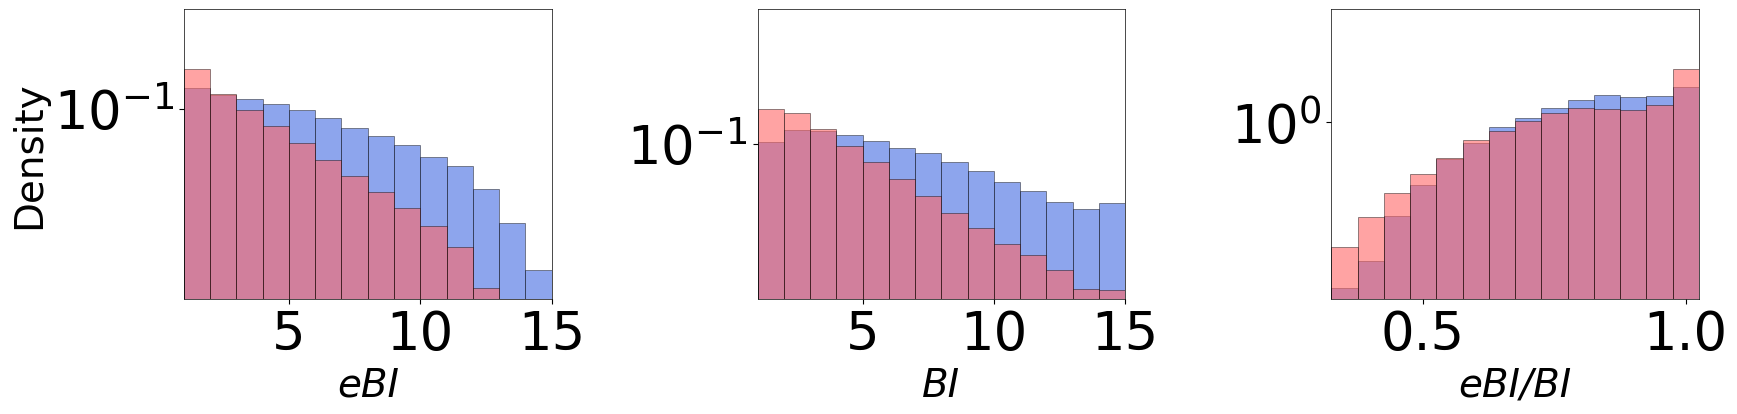

In [29]:
obs_list = []

for river_folder in os.listdir(root_dir):
    river_path = os.path.join(root_dir, river_folder)
    if os.path.isdir(river_path):
        rivgraph_path = os.path.join(river_path, 'rivgraph')
        if os.path.isdir(rivgraph_path):
            ebi_annual_file = os.path.join(rivgraph_path, 'eBI_results_annual.csv')
            bi_annual_file = os.path.join(rivgraph_path, 'BI_results_annual.csv')
            
            if os.path.exists(ebi_annual_file) and os.path.exists(bi_annual_file):
                try:
                    ebi_df = pd.read_csv(ebi_annual_file)
                    bi_df = pd.read_csv(bi_annual_file)
                except Exception as e:
                    print(f"Error reading annual files for {river_folder}: {e}")
                    continue
                
                # Merge eBI and BI data on [Year, Cross_section]
                merged_df = pd.merge(ebi_df, bi_df, on=['Year', 'Cross_section'], how='inner')
                merged_df['River'] = river_folder
                obs_list.append(merged_df)
            else:
                print(f"Missing annual files for river {river_folder}.")

if obs_list:
    all_obs_df = pd.concat(obs_list, ignore_index=True)
else:
    print("No observations found.")
    all_obs_df = pd.DataFrame()

# --- Step 2. Load classification info from combined statistics CSV ---
combined_stats_path = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_combined_statistics.csv"
try:
    df_stats = pd.read_csv(combined_stats_path, usecols=['River', 'Classification'])
except Exception as e:
    print(f"Error reading combined statistics file: {e}")
    df_stats = pd.DataFrame()

merged_obs_df = pd.merge(all_obs_df, df_stats, on='River', how='left')

# --- Step 3. Compute eBI/BI ratio for each observation ---
merged_obs_df['ratio'] = merged_obs_df['eBI'] / merged_obs_df['BI']

# --- Step 4. Split data into Braided and Wandering groups ---
braided_obs = merged_obs_df[merged_obs_df['Classification'] == 'B']
wandering_obs = merged_obs_df[merged_obs_df['Classification'].isin(['HSW', 'LSW'])]

# Remove any data where eBI > 15 or BI > 15 for both braided and wandering
braided_obs = braided_obs[(braided_obs['eBI'] <= 15) & (braided_obs['BI'] <= 15)]
wandering_obs = wandering_obs[(wandering_obs['eBI'] <= 15) & (wandering_obs['BI'] <= 15)]

# --- Step 5. Plot combined histograms for eBI, BI, and eBI/BI ratio ---
colors = {'B': '#4169E1', 'Wandering': '#FF6666'}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Define bins of size 1 for eBI and BI (from 1 to 15)
bins_1_to_15 = range(1, 16)

# 1) eBI histogram
axes[0].hist(
    braided_obs['eBI'], bins=bins_1_to_15, 
    edgecolor='black', linewidth=0.5,  # thinner bin edges
    alpha=0.6, density=True, color=colors['B'], 
    label=f'Braided (n={len(braided_obs["eBI"])})'
)
axes[0].hist(
    wandering_obs['eBI'], bins=bins_1_to_15, 
    edgecolor='black', linewidth=0.5,  # thinner bin edges
    alpha=0.6, density=True, color=colors['Wandering'], 
    label=f'Wandering (n={len(wandering_obs["eBI"])})'
)
axes[0].set_xlabel('eBI', fontstyle='italic')
axes[0].set_ylabel('Density')
axes[0].set_yscale('log')
axes[0].set_xlim(1, 15)
axes[0].set_ylim(top=10)

# 2) BI histogram
axes[1].hist(
    braided_obs['BI'], bins=bins_1_to_15, 
    edgecolor='black', linewidth=0.5,  # thinner bin edges
    alpha=0.6, density=True, color=colors['B'], 
    label=f'Braided (n={len(braided_obs["BI"])})'
)
axes[1].hist(
    wandering_obs['BI'], bins=bins_1_to_15, 
    edgecolor='black', linewidth=0.5,  # thinner bin edges
    alpha=0.6, density=True, color=colors['Wandering'], 
    label=f'Wandering (n={len(wandering_obs["BI"])})'
)
axes[1].set_xlabel('BI', fontstyle='italic')
axes[1].set_yscale('log')
axes[1].set_xlim(1, 15)
axes[1].set_ylim(top=10)

# 3) eBI/BI ratio histogram
# Determine the overall min and max for the ratio from both datasets.
min_ratio = min(braided_obs['ratio'].min(), wandering_obs['ratio'].min())
max_ratio = max(braided_obs['ratio'].max(), wandering_obs['ratio'].max())

hist_bins = np.arange(min_ratio, max_ratio + 0.05, 0.05)
axes[2].hist(
    braided_obs['ratio'], bins=hist_bins, 
    edgecolor='black', linewidth=0.5,  # thinner bin edges
    alpha=0.6, density=True, color=colors['B'], 
    label=f'Braided (n={len(braided_obs["ratio"])})'
)
axes[2].hist(
    wandering_obs['ratio'], bins=hist_bins, 
    edgecolor='black', linewidth=0.5,  # thinner bin edges
    alpha=0.6, density=True, color=colors['Wandering'], 
    label=f'Wandering (n={len(wandering_obs["ratio"])})'
)
axes[2].set_xlabel('eBI/BI', fontstyle='italic')
axes[2].set_yscale('log')
axes[2].set_ylim(top=100)
axes[2].set_xlim(hist_bins[0], hist_bins[-1])

# Adjust spines and tick params
for ax in axes:
    ax.grid(False)
    # Make spines thinner
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)   # thinner subplot outline
    
    # Ticks
    ax.tick_params(
        axis='both', which='both',
        direction='out', colors='black',
        bottom=True, left=True
    )

plt.tight_layout()
plt.show()



fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\3_histograms.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

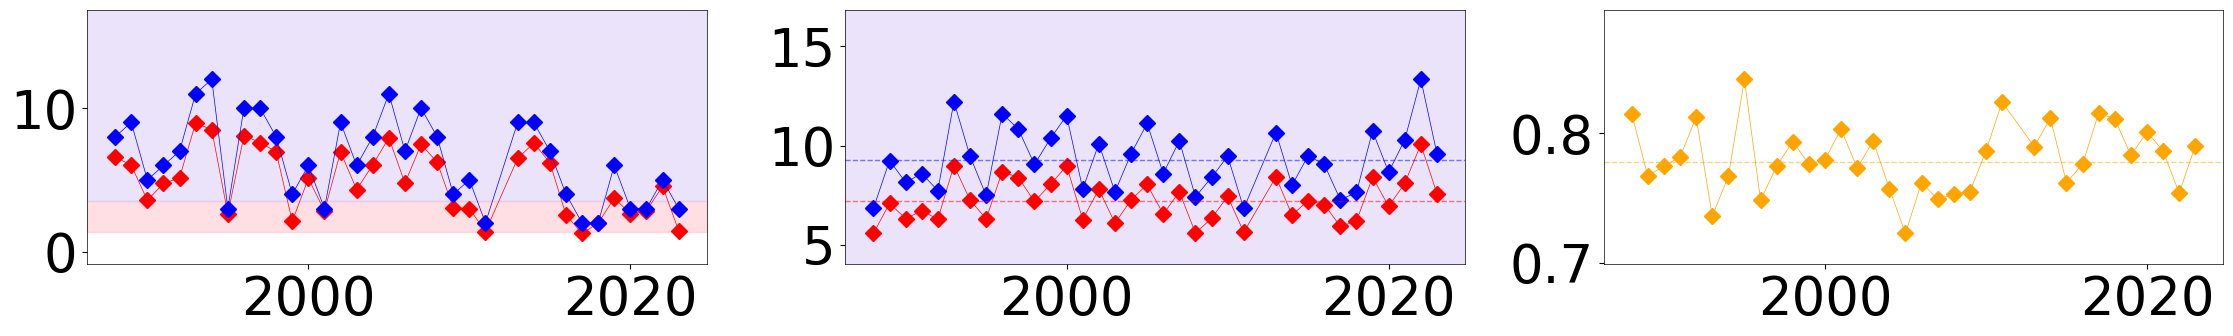

In [23]:

# Braided river
target_river = "Brahmaputra_Pandu"
root_dir     = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_results"
rivgraph_path = os.path.join(root_dir, target_river, "rivgraph")

# Read and merge
ebi_df    = pd.read_csv(os.path.join(rivgraph_path, "eBI_results_annual.csv"))
bi_df     = pd.read_csv(os.path.join(rivgraph_path, "BI_results_annual.csv"))
merged_df = pd.merge(ebi_df, bi_df, on=["Year","Cross_section"], how="inner")

# Clean Year
merged_df["Year"] = pd.to_numeric(merged_df["Year"], errors="coerce").astype("Int64")
merged_df = merged_df.dropna(subset=["Year"])
merged_df["Year"] = merged_df["Year"].astype(int)

# Data for subplot 1
df_target = merged_df[merged_df["Cross_section"] == 5].sort_values("Year")

# Data for subplots 2 & 3
yearly_avg      = merged_df.groupby("Year").agg({"eBI":"mean","BI":"mean"}).reset_index()
overall_ebi_avg = yearly_avg["eBI"].mean()
overall_bi_avg  = yearly_avg["BI"].mean()
overall_ratio   = overall_ebi_avg / overall_bi_avg

# Create a 1×3 row of subplots
fig, axes = plt.subplots(1, 3, figsize=(23, 4), sharex=True)

ebi_color    = "red"
bi_color     = "blue"
ratio_color  = "orange"   # changed from purple to orange
marker_style = "D"
marker_size  = 8
linw         = 0.5
# Shading thresholds and colors
low_lower  = 1.4
low_upper  = 3.5
high_lower = 3.5
high_upper = 20

pink_color = 'pink'
blue_color = '#d6c8f4'
shade_alpha = 0.5  # transparency

# Subplot 1: site-level eBI & BI
axes[0].plot(df_target["Year"], df_target["eBI"],
             marker=marker_style, markersize=marker_size,
             color=ebi_color, linestyle='-', linewidth=linw)
axes[0].plot(df_target["Year"], df_target["BI"],
             marker=marker_style, markersize=marker_size,
             color=bi_color, linestyle='-', linewidth=linw)
axes[0].tick_params(axis='both')
axes[0].axhspan(low_lower, low_upper,  color=pink_color, alpha=shade_alpha, zorder=0)
axes[0].axhspan(high_lower, high_upper, color=blue_color, alpha=shade_alpha, zorder=0)
axes[0].grid(False)

# Subplot 2: reach-level mean eBI & BI with dashed averages
axes[1].plot(yearly_avg["Year"], yearly_avg["eBI"],
             marker=marker_style, markersize=marker_size,
             color=ebi_color, linestyle='-', linewidth=linw)
axes[1].plot(yearly_avg["Year"], yearly_avg["BI"],
             marker=marker_style, markersize=marker_size,
             color=bi_color, linestyle='-', linewidth=linw)
axes[1].axhline(overall_ebi_avg, color=ebi_color, linestyle='--', linewidth=1, alpha=0.5)
axes[1].axhline(overall_bi_avg,  color=bi_color, linestyle='--', linewidth=1, alpha=0.5)
axes[1].axhspan(low_lower, low_upper,  color=pink_color, alpha=shade_alpha, zorder=0)
axes[1].axhspan(high_lower, high_upper, color=blue_color, alpha=shade_alpha, zorder=0)
axes[1].tick_params(axis='both')
axes[1].grid(False)

# Subplot 3: time series of eBI/BI + mean ratio dashed line
ratio_ts = yearly_avg["eBI"] / yearly_avg["BI"]
axes[2].plot(yearly_avg["Year"], ratio_ts,
             marker=marker_style, markersize=marker_size,
             color=ratio_color, linestyle='-', linewidth=linw)
axes[2].axhline(overall_ratio,
                color=ratio_color, linestyle='--', linewidth=1, alpha=0.5)
axes[2].tick_params(axis='both')
axes[2].grid(False)

bottom_pad_frac = 0.20
top_pad_frac    = 0.45

for ax in axes:
    # pull all plotted y‐data
    ys = np.hstack([ln.get_ydata() for ln in ax.get_lines()])
    ys = ys[np.isfinite(ys)]
    if ys.size:
        ymin, ymax = ys.min(), ys.max()
        yrange      = ymax - ymin
        bottom_pad  = yrange * bottom_pad_frac
        top_pad     = yrange * top_pad_frac
        ax.set_ylim(ymin - bottom_pad, ymax + top_pad)
        
# Common formatting
for ax in axes:
    ax.tick_params(direction='out', bottom=True, left=True)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)



plt.tight_layout()
plt.show()

# Save
fig.savefig(
    r"C:\Users\Feifei\Box\BR_remote_sensing\figures\5_time_series_Brahm.pdf",
    format='pdf', dpi=500, bbox_inches='tight', transparent=True
)



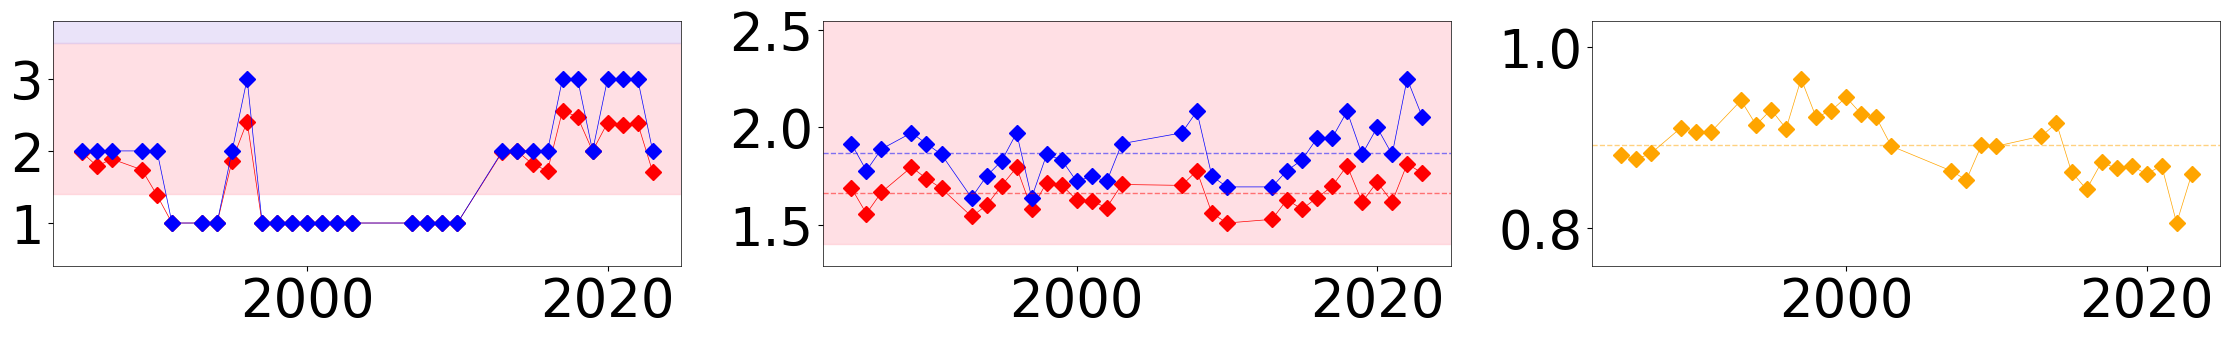

In [24]:
# Wandering

# Specify the target river folder "Magdalena_Calamar"
target_river = "Magdalena_Calamar"
root_dir     = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_results"
rivgraph_path = os.path.join(root_dir, target_river, "rivgraph")

# Read and merge
ebi_df    = pd.read_csv(os.path.join(rivgraph_path, "eBI_results_annual.csv"))
bi_df     = pd.read_csv(os.path.join(rivgraph_path, "BI_results_annual.csv"))
merged_df = pd.merge(ebi_df, bi_df, on=["Year","Cross_section"], how="inner")

# Clean Year
merged_df["Year"] = pd.to_numeric(merged_df["Year"], errors="coerce").astype("Int64")
merged_df = merged_df.dropna(subset=["Year"])
merged_df["Year"] = merged_df["Year"].astype(int)

# Data for subplot 1
df_target = merged_df[merged_df["Cross_section"] == 20].sort_values("Year")

# Data for subplots 2 & 3
yearly_avg      = merged_df.groupby("Year").agg({"eBI":"mean","BI":"mean"}).reset_index()
overall_ebi_avg = yearly_avg["eBI"].mean()
overall_bi_avg  = yearly_avg["BI"].mean()
overall_ratio   = overall_ebi_avg / overall_bi_avg

# Create a 1×3 row of subplots
fig, axes = plt.subplots(1, 3, figsize=(23, 4), sharex=True)

ebi_color    = "red"
bi_color     = "blue"
ratio_color  = "orange"   # changed from purple to orange
marker_style = "D"
marker_size  = 8
linw         = 0.5
# Shading thresholds and colors
low_lower  = 1.4
low_upper  = 3.5
high_lower = 3.5
high_upper = 20

pink_color = 'pink'
blue_color = '#d6c8f4'
shade_alpha = 0.5  # transparency
# Subplot 1: site-level eBI & BI
axes[0].plot(df_target["Year"], df_target["eBI"],
             marker=marker_style, markersize=marker_size,
             color=ebi_color, linestyle='-', linewidth=linw)
axes[0].plot(df_target["Year"], df_target["BI"],
             marker=marker_style, markersize=marker_size,
             color=bi_color, linestyle='-', linewidth=linw)
axes[0].axhspan(low_lower, low_upper,  color=pink_color, alpha=shade_alpha, zorder=0)
axes[0].axhspan(high_lower, high_upper, color=blue_color, alpha=shade_alpha, zorder=0)
axes[0].tick_params(axis='both')
axes[0].grid(False)

# Subplot 2: reach-level mean eBI & BI with dashed averages
axes[1].plot(yearly_avg["Year"], yearly_avg["eBI"],
             marker=marker_style, markersize=marker_size,
             color=ebi_color, linestyle='-', linewidth=linw)
axes[1].plot(yearly_avg["Year"], yearly_avg["BI"],
             marker=marker_style, markersize=marker_size,
             color=bi_color, linestyle='-', linewidth=linw)
axes[1].axhline(overall_ebi_avg, color=ebi_color, linestyle='--', linewidth=1, alpha=0.5)
axes[1].axhline(overall_bi_avg,  color=bi_color, linestyle='--', linewidth=1, alpha=0.5)
axes[1].axhspan(low_lower, low_upper,  color=pink_color, alpha=shade_alpha, zorder=0)
axes[1].axhspan(high_lower, high_upper, color=blue_color, alpha=shade_alpha, zorder=0)
axes[1].tick_params(axis='both')
axes[1].grid(False)

# Subplot 3: time series of eBI/BI + mean ratio dashed line
ratio_ts = yearly_avg["eBI"] / yearly_avg["BI"]
axes[2].plot(yearly_avg["Year"], ratio_ts,
             marker=marker_style, markersize=marker_size,
             color=ratio_color, linestyle='-', linewidth=linw)
axes[2].axhline(overall_ratio,
                color=ratio_color, linestyle='--', linewidth=1, alpha=0.5)
axes[2].tick_params(axis='both')
axes[2].grid(False)

bottom_pad_frac = 0.3
top_pad_frac    = 0.40

for ax in axes:
    # pull all plotted y‐data
    ys = np.hstack([ln.get_ydata() for ln in ax.get_lines()])
    ys = ys[np.isfinite(ys)]
    if ys.size:
        ymin, ymax = ys.min(), ys.max()
        yrange      = ymax - ymin
        bottom_pad  = yrange * bottom_pad_frac
        top_pad     = yrange * top_pad_frac
        ax.set_ylim(ymin - bottom_pad, ymax + top_pad)
        
# Common formatting
for ax in axes:
    ax.tick_params(direction='out', bottom=True, left=True)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)



plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\5_time_series_magdalena.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

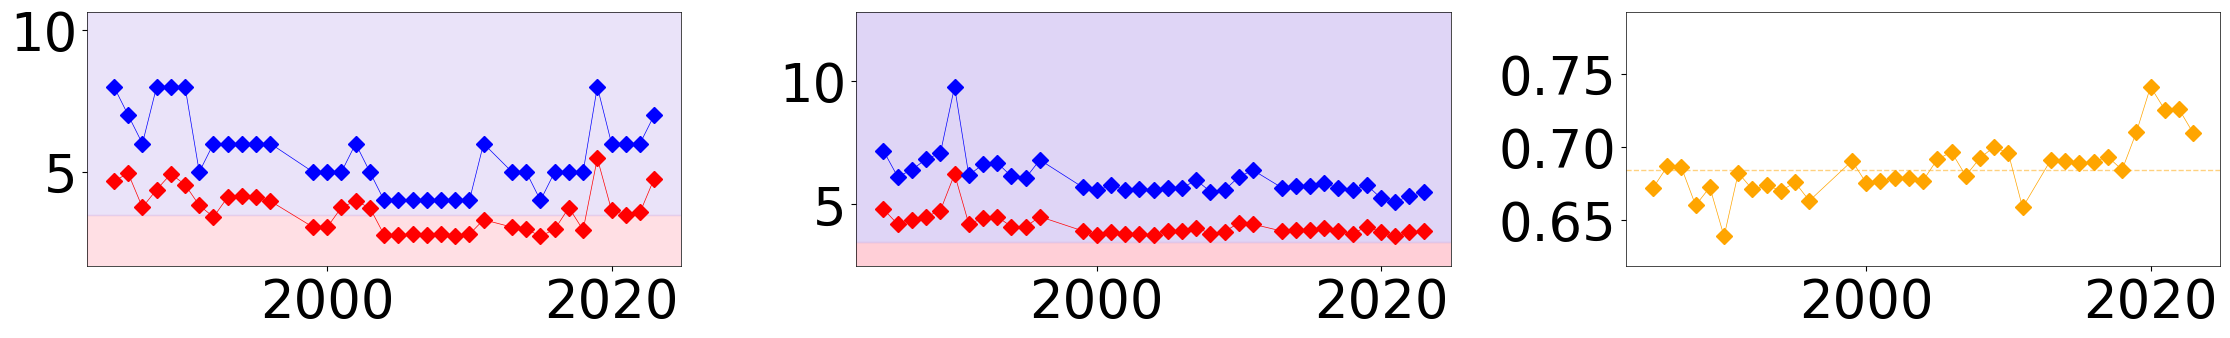

In [25]:
# Wandering & Braided in between 

target_river = "Parana_Corrientes"

root_dir     = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_results"
rivgraph_path = os.path.join(root_dir, target_river, "rivgraph")

# Read and merge
ebi_df    = pd.read_csv(os.path.join(rivgraph_path, "eBI_results_annual.csv"))
bi_df     = pd.read_csv(os.path.join(rivgraph_path, "BI_results_annual.csv"))
merged_df = pd.merge(ebi_df, bi_df, on=["Year","Cross_section"], how="inner")

# Clean Year
merged_df["Year"] = pd.to_numeric(merged_df["Year"], errors="coerce").astype("Int64")
merged_df = merged_df.dropna(subset=["Year"])
merged_df["Year"] = merged_df["Year"].astype(int)

# Data for subplot 1
df_target = merged_df[merged_df["Cross_section"] == 20].sort_values("Year")

# Data for subplots 2 & 3
yearly_avg      = merged_df.groupby("Year").agg({"eBI":"mean","BI":"mean"}).reset_index()
overall_ebi_avg = yearly_avg["eBI"].mean()
overall_bi_avg  = yearly_avg["BI"].mean()
overall_ratio   = overall_ebi_avg / overall_bi_avg

# Create a 1×3 row of subplots
fig, axes = plt.subplots(1, 3, figsize=(23, 4), sharex=True)

ebi_color    = "red"
bi_color     = "blue"
ratio_color  = "orange"   # changed from purple to orange
marker_style = "D"
marker_size  = 8
linw         = 0.5
low_lower  = 1.4
low_upper  = 3.5
high_lower = 3.5
high_upper = 20

pink_color = 'pink'
blue_color = '#d6c8f4'
shade_alpha = 0.5  # transparency

# Subplot 1: site-level eBI & BI
axes[0].plot(df_target["Year"], df_target["eBI"],
             marker=marker_style, markersize=marker_size,
             color=ebi_color, linestyle='-', linewidth=linw)
axes[0].plot(df_target["Year"], df_target["BI"],
             marker=marker_style, markersize=marker_size,
             color=bi_color, linestyle='-', linewidth=linw)
axes[0].axhspan(low_lower, low_upper,  color=pink_color, alpha=shade_alpha, zorder=0)
axes[0].axhspan(high_lower, high_upper, color=blue_color, alpha=shade_alpha, zorder=0)
axes[0].tick_params(axis='both')
axes[0].grid(False)

# Subplot 2: reach-level mean eBI & BI with dashed averages
axes[1].plot(yearly_avg["Year"], yearly_avg["eBI"],
             marker=marker_style, markersize=marker_size,
             color=ebi_color, linestyle='-', linewidth=linw)
axes[1].plot(yearly_avg["Year"], yearly_avg["BI"],
             marker=marker_style, markersize=marker_size,
             color=bi_color, linestyle='-', linewidth=linw)
axes[1].axhspan(low_lower, low_upper,  color=pink_color, alpha=shade_alpha, zorder=0)
axes[1].axhspan(high_lower, high_upper, color=blue_color, alpha=shade_alpha, zorder=0)
axes[1].axhspan(low_lower, low_upper,  color=pink_color, alpha=shade_alpha, zorder=0)
axes[1].axhspan(high_lower, high_upper, color=blue_color, alpha=shade_alpha, zorder=0)
axes[1].tick_params(axis='both')
axes[1].grid(False)

# Subplot 3: time series of eBI/BI + mean ratio dashed line
ratio_ts = yearly_avg["eBI"] / yearly_avg["BI"]
axes[2].plot(yearly_avg["Year"], ratio_ts,
             marker=marker_style, markersize=marker_size,
             color=ratio_color, linestyle='-', linewidth=linw)
axes[2].axhline(overall_ratio,
                color=ratio_color, linestyle='--', linewidth=1, alpha=0.5)
axes[2].tick_params(axis='both')
axes[2].grid(False)

bottom_pad_frac = 0.20
top_pad_frac    = 0.50

for ax in axes:
    # pull all plotted y‐data
    ys = np.hstack([ln.get_ydata() for ln in ax.get_lines()])
    ys = ys[np.isfinite(ys)]
    if ys.size:
        ymin, ymax = ys.min(), ys.max()
        yrange      = ymax - ymin
        bottom_pad  = yrange * bottom_pad_frac
        top_pad     = yrange * top_pad_frac
        ax.set_ylim(ymin - bottom_pad, ymax + top_pad)
        
# Common formatting
for ax in axes:
    ax.tick_params(direction='out', bottom=True, left=True)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)



plt.tight_layout()
plt.show()

# Save
fig.savefig(
    r"C:\Users\Feifei\Box\BR_remote_sensing\figures\5_time_series_Parana.pdf",
    format='pdf', dpi=500, bbox_inches='tight', transparent=True
)
